# Script Suavizado de caudales

### Suavizado de Series Temporales

**¿Por qué suavizar las series antes de proyectar?**

El suavizado de series temporales es una técnica clave para eliminar fluctuaciones aleatorias y ruidos en los datos, lo que facilita la identificación de patrones y tendencias subyacentes. En el contexto de la predicción de caudales, el suavizado permite observar el comportamiento general de los flujos de agua sin la interferencia de variaciones extremas o picos que podrían sesgar el modelo predictivo.

#### Beneficios de Suavizar las Series Temporales:
1. **Reducción del Ruido**: Las mediciones de caudal pueden estar influenciadas por factores externos, errores en las mediciones, o anomalías temporales. Al suavizar los datos, eliminamos estas variaciones menores, lo cual mejora la calidad de los datos que alimentarán al modelo.
   
2. **Enfoque en Tendencias y Estacionalidad**: El suavizado resalta los patrones que se mantienen constantes a lo largo del tiempo, como tendencias a largo plazo y ciclos estacionales. Esto ayuda a que el modelo de predicción identifique mejor estos patrones, facilitando proyecciones más precisas.
   
3. **Evita el Overfitting**: Modelos que utilizan series temporales sin suavizar pueden "ajustarse demasiado" a los valores ruidosos y extremos, generando predicciones poco realistas. Con el suavizado, el modelo es más robusto y se centra en los patrones estructurales de los datos.

#### Técnicas de Suavizado
En este ejercicio, la serie ha sido previamente descompuesta con **STL** en componentes de **tendencia** y **estacionalidad**, permitiendo aislar el **ruido** (residuales y estacionalidad no explicada). Este componente de ruido ahora puede ser atenuado o eliminado mediante técnicas de suavizado, resultando en una serie temporal optimizada para la proyección.

### Aplicación en el Ejercicio
Antes de realizar las proyecciones de caudal, el suavizado de la serie temporal asegura que el modelo esté basado en datos claros y estructurados, alineados con el comportamiento real de los pozos de extracción. Esto permite que las proyecciones finales sean más precisas, confiables y representativas de los cambios reales en el flujo de caudal.

En resumen, el suavizado es un paso crítico para reducir el impacto de fluctuaciones aleatorias y garantizar que las proyecciones se centren en los patrones principales, proporcionando una base sólida para decisiones de gestión de recursos hídricos.


## 1-Librerías

In [2]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from statsmodels.tsa.seasonal import STL
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from patsy.highlevel import dmatrix
from pandas.plotting import register_matplotlib_converters

warnings.filterwarnings('ignore') # Para evitar los molestos avisos.
register_matplotlib_converters()

## 2-Datos de entrada

In [3]:
def load_excel_data(file_path: str) -> pd.DataFrame:
    """Load data from an Excel file.

    Args:
        file_path: Path to the Excel file.

    Returns:
        DataFrame containing the loaded data.
    """
    df = pd.read_excel(file_path, index_col=0)
    print(df)
    return df

In [4]:
file_path = r"E:\9_Desarrollo\UDD\Analisis_de_Datos\Notebook\Q_Filtrado_STL_Hampel.xlsx"
df_input = load_excel_data(file_path)

           Pozo      Fecha  Q_medio_mensual_l/s  Outlier  Caudal_filtrado
0      ARPES-01 2014-01-01             6.658555    False         6.658555
1      ARPES-01 2014-02-01             7.717431    False         7.717431
2      ARPES-01 2014-03-01             7.663063    False         7.663063
3      ARPES-01 2014-04-01             7.573851    False         7.573851
4      ARPES-01 2014-05-01             5.465879     True              NaN
...         ...        ...                  ...      ...              ...
41221   XP17-05 2024-06-01             0.274481    False         0.274481
41222   XP17-05 2024-08-01             0.070146     True              NaN
41223   XP17-05 2024-09-01             0.100827     True              NaN
41224   XP17-05 2024-10-01             0.841751     True              NaN
41225   XP17-05 2024-12-01             0.211238    False         0.211238

[41226 rows x 5 columns]


In [5]:
df_result = df_input[['Pozo', 'Fecha','Q_medio_mensual_l/s', 'Outlier','Caudal_filtrado']].copy()
df_result=df_result.rename(columns={'Pozo':'Pozo', 'Fecha':'Fecha','Q_medio_mensual_l/s':'Caudal (L/s)', 'Outlier':'Outlier','Caudal_filtrado':'Caudal_Filtrado'})
df_result.head()

,Pozo,Fecha,Caudal (L/s),Outlier,Caudal_Filtrado
0,ARPES-01,2014-01-01,6.658555,False,6.658555
1,ARPES-01,2014-02-01,7.717431,False,7.717431
2,ARPES-01,2014-03-01,7.663063,False,7.663063
3,ARPES-01,2014-04-01,7.573851,False,7.573851
4,ARPES-01,2014-05-01,5.465879,True,NaN


## 3-Suavizado de series

### 3.1- 1° Opción de suavizado - Modelo Spline Cúbico Natural

In [6]:
# Definir la función para el modelo de spline cúbico natural
def get_natural_cubic_spline_model(x, y, n_knots=5):
    # Asegurarse de que no hay NaNs en los datos
    mask = ~np.isnan(y)
    x, y = x[mask], y[mask]
    
    # Si no hay suficientes datos después de eliminar NaNs, devolver None
    if len(x) <= n_knots:
        return None, None
    
    # Generar ubicaciones de nudos basadas en cuantiles de x
    knots = np.quantile(x, np.linspace(0, 1, n_knots + 2)[1:-1])
    # Crear la matriz de diseño para splines cúbicos con los nudos dados
    transformed_x = dmatrix("bs(x, knots=knots, degree=3, include_intercept=False)", {"x": x}, return_type='dataframe')
    # Ajustar un modelo lineal a la expansión de base de spline
    model = LinearRegression()
    model.fit(transformed_x, y)
    # Devolver el modelo ajustado y los nudos
    return model, knots

# Aplicar el suavizado spline a la columna 'Caudal_Filtrado' (sin outliers)
# Crear una nueva columna para almacenar los valores suavizados
df_result['Caudal_Filtrado_Suavizado(Spline)'] = np.nan

# Definir el número de nudos para el spline, puede necesitar ajuste
n_knots = 5

# Aplicar el suavizado spline por Pozo
for pozo in df_result['Pozo'].unique():
    # Seleccionar datos por pozo que no son outliers
    mask = df_result['Pozo'] == pozo
    if np.sum(mask) > n_knots + 2:
        # Preparar datos para el modelo
        x = np.arange(np.sum(mask))
        y = df_result.loc[mask, 'Caudal_Filtrado']
        # Obtener modelo de spline cúbico natural
        model, knots = get_natural_cubic_spline_model(x, y, n_knots)
        if model is not None:
            # Predecir y guardar valores suavizados
            X_spline = dmatrix("bs(x, knots=knots, degree=3, include_intercept=False)", {"x": x}, return_type='dataframe')
            df_result.loc[mask, 'Caudal_Filtrado_Suavizado(Spline)'] = model.predict(X_spline)

#Sacar los tramos de Splin donde se eliminaron Outliers
df_result['Caudal_Filtrado_Suavizado(Spline)'] = np.where(df_result['Outlier'] == False, df_result['Caudal_Filtrado_Suavizado(Spline)'], np.nan)

# Visualizar los primeros registros con la nueva columna
df_result.head()

,Pozo,Fecha,Caudal (L/s),Outlier,Caudal_Filtrado,Caudal_Filtrado_Suavizado(Spline)
0,ARPES-01,2014-01-01,6.658555,False,6.658555,6.991488
1,ARPES-01,2014-02-01,7.717431,False,7.717431,7.218042
2,ARPES-01,2014-03-01,7.663063,False,7.663063,7.411679
3,ARPES-01,2014-04-01,7.573851,False,7.573851,7.574224
4,ARPES-01,2014-05-01,5.465879,True,NaN,NaN


### 3.2- 2° Opción de suavizado - STL Trend más ruido atenuado

#### Métdo:
 - Se aplica una descomposición STL a la serie, separandola en Tendencia, Estacionalida y Residuo. Pero esta vez se aplica sobre los caudales filtrados.
 - Luego de la descoposición se suman los Residuos con la Estacionaidad. La adición de ambas componentes es considerado como Ruido.
 - En aquellos puntos o intervalos de las serie donde la magnitud del Ruido supera un cierto valor establecido (algún cuantil de la Serie Ruido), se aplica un suavizado. Mientras que en aquellos puntos donde el Ruido no supera el valor establecido se mantienen los mismos valores de caudal filtrado.
 - El suavizado, aplicado en aquellos tramos en los que determine el criterio anterior, consiste en añadir más o menos Ruido a la Tendencia. El nivel de Ruido incorporado a la tendencia dependerá del nivel de suavizado indicado (de 0 a 100%). Es decir Caudal_Suavizado = Tendencia + (0-100%)*Ruido.
 - El método completo requiere 3 parámetros definidos por el usuario (y tambien asignados por defecto), estos son:
   -  Periodo: numero de datos que conforman un periodo. Este parámetro es esencial para el STL, de él depende la forma de la tendencia y de las otras componentes.
   -  Cuantil: cuantil de la distribución de la serie de Ruido (Residuo + Estaciolidad). Establece un límite de Ruido "aceptable".
   - Suavizado: % de ruido que se quiere eliminar en aquellos tramos que superen el nivel de ruido aceptable.

In [7]:
#Parámetros que controlan el nivel de suavizado con STL.
Periodo = 15
Cuantil = 0.65
Suavizado=95 #%

In [8]:
# Crear un nuevo DataFrame para guardar los resultados
df_result_SuaveSTL = pd.DataFrame()

In [9]:
#STL sobre datos filtrados

#Se interpolan datos filtrados para que STL pueda funcionar
df_result['Caudal_Filtrado_interp'] = df_result['Caudal_Filtrado'].interpolate()

# Iterar por cada pozo
for pozo in df_result['Pozo'].unique():
    # Filtrar los datos por pozo
    df_temp = df_result[df_result['Pozo'] == pozo]

    if not df_temp.empty:
        # Aplicar STL y guardar los resultados en el DataFrame
        stl = STL(df_temp['Caudal_Filtrado_interp'], period=Periodo, seasonal=9)
        result = stl.fit()

        # Guardar los componentes de la descomposición STL en el DataFrame
        df_temp['Trend2'] = result.trend
        df_temp['Seasonal2'] = result.seasonal
        df_temp['Resid2'] = result.resid

        # Juntar los resultados de cada iteración
        df_result_SuaveSTL = pd.concat([df_result_SuaveSTL, df_temp])

In [10]:
# Crear una nueva columna para almacenar los valores suavizados
df_result_SuaveSTL['Caudal_Filtrado_Suavizado(STL)'] = np.nan

#Aplicar suavizado en tramos con ruido mayor al límite definido (Cuantil)
Ruido2 = df_result_SuaveSTL['Resid2'] + df_result_SuaveSTL['Seasonal2']
AplicarSuavizado = df_result_SuaveSTL['Trend2']  + (100-Suavizado)*0.01*Ruido2
df_result_SuaveSTL['Caudal_Filtrado_Suavizado(STL)'] = np.where(abs(Ruido2) < abs(Ruido2.quantile(Cuantil)), df_result['Caudal_Filtrado'], AplicarSuavizado)
df_result_SuaveSTL['Caudal_Filtrado_Suavizado(STL)'] = np.where(df_result_SuaveSTL['Outlier'] == False, df_result_SuaveSTL['Caudal_Filtrado_Suavizado(STL)'], np.nan)

In [11]:
# Tomar solo las columnas de interes
df_result_final=df_result_SuaveSTL[['Pozo','Fecha','Caudal (L/s)','Outlier', 'Caudal_Filtrado', 'Caudal_Filtrado_Suavizado(Spline)', 'Caudal_Filtrado_Suavizado(STL)']].copy()
df_result_final

,Pozo,Fecha,Caudal (L/s),Outlier,Caudal_Filtrado,Caudal_Filtrado_Suavizado(Spline),Caudal_Filtrado_Suavizado(STL)
0,ARPES-01,2014-01-01,6.658555,False,6.658555,6.991488,7.323592
1,ARPES-01,2014-02-01,7.717431,False,7.717431,7.218042,7.416898
2,ARPES-01,2014-03-01,7.663063,False,7.663063,7.411679,7.453383
3,ARPES-01,2014-04-01,7.573851,False,7.573851,7.574224,7.486891
4,ARPES-01,2014-05-01,5.465879,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...
41221,XP17-05,2024-06-01,0.274481,False,0.274481,0.257248,0.274481
41222,XP17-05,2024-08-01,0.070146,True,NaN,NaN,NaN
41223,XP17-05,2024-09-01,0.100827,True,NaN,NaN,NaN
41224,XP17-05,2024-10-01,0.841751,True,NaN,NaN,NaN


In [12]:
# En caso de que los métodos de suavizado fallen (en pozos con pocos datos) agregar caudales sin suavizar en las columnas de Spline y STL
df_result_final['Caudal_Filtrado_Suavizado(Spline)'] = np.where(np.isnan(df_result_final['Caudal_Filtrado_Suavizado(Spline)']), df_result_final['Caudal_Filtrado'], df_result_final['Caudal_Filtrado_Suavizado(Spline)'])
df_result_final['Caudal_Filtrado_Suavizado(STL)'] = np.where(np.isnan(df_result_final['Caudal_Filtrado_Suavizado(STL)']), df_result_final['Caudal_Filtrado'], df_result_final['Caudal_Filtrado_Suavizado(STL)'])


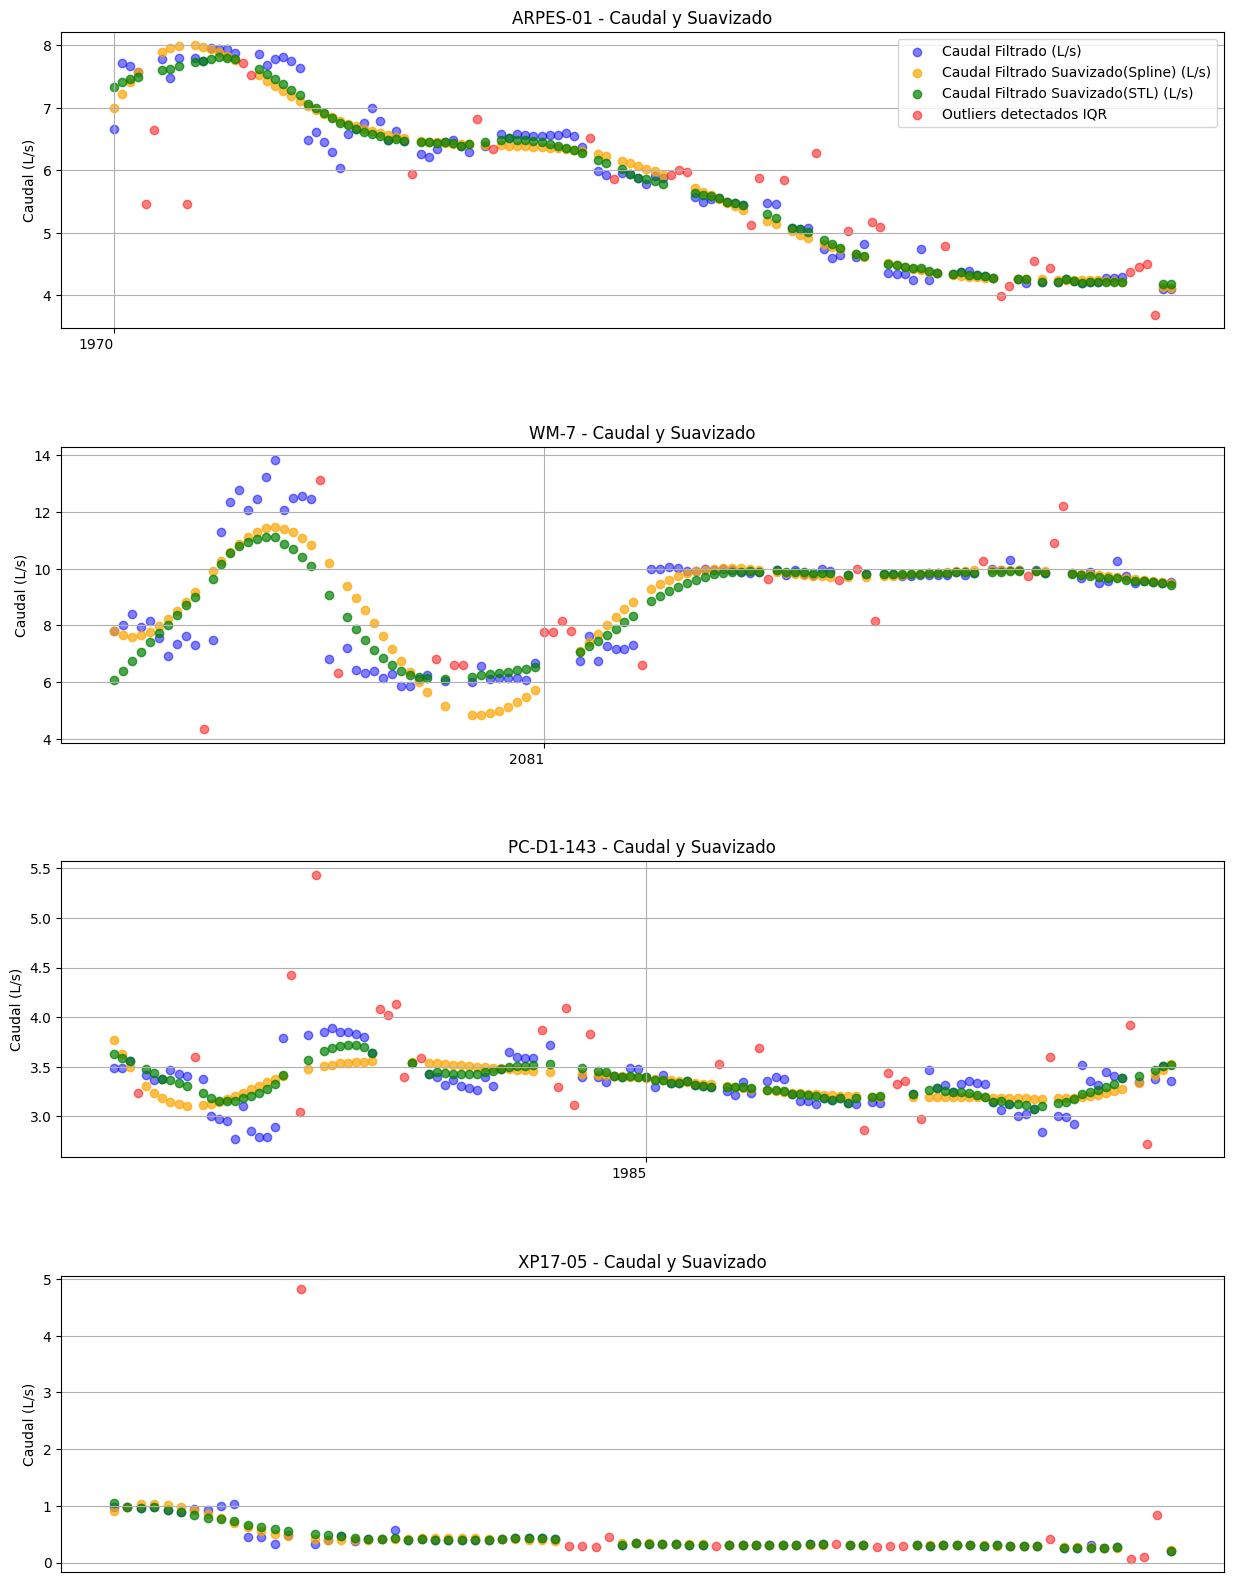

In [13]:
# Lista de pozos para graficar.
pozos = ['ARPES-01', 'WM-7', 'PC-D1-143', 'XP17-05']

# Configurar el tamaño de la figura para que cada subplot tenga un aspecto más proporcionado.
fig, axes = plt.subplots(nrows=len(pozos), ncols=1, figsize=(15, 5 * len(pozos)))

# Iterar sobre cada pozo y crear los gráficos.
for i, pozo in enumerate(pozos):
    # Filtramos por el pozo actual.
    df_pozo = df_result_final[df_result_final['Pozo'] == pozo]

    # Graficar la serie de tiempo filtrada.
    axes[i].scatter(df_pozo.index, df_pozo['Caudal_Filtrado'], color='blue', label='Caudal Filtrado (L/s)', alpha=0.5)
    
    # Graficar la serie de tiempo suavizada(Spline).
    axes[i].scatter(df_pozo.index, df_pozo['Caudal_Filtrado_Suavizado(Spline)'], color='orange', label='Caudal Filtrado Suavizado(Spline) (L/s)', alpha=0.7)

    # Graficar la serie de tiempo suavizada(STL).
    axes[i].scatter(df_pozo.index, df_pozo['Caudal_Filtrado_Suavizado(STL)'], color='green', label='Caudal Filtrado Suavizado(STL) (L/s)', alpha=0.7)
    
    # Graficar los outliers.
    outliers = df_pozo['Outlier'] & df_pozo['Caudal (L/s)'].notna()
    axes[i].scatter(df_pozo.index[outliers], df_pozo['Caudal (L/s)'][outliers], color='red', label='Outliers detectados IQR', marker='o', alpha=0.5)

    # Configurar las etiquetas y título del gráfico.
    axes[i].set_title(f'{pozo} - Caudal y Suavizado')
    axes[i].set_ylabel('Caudal (L/s)')
    
    # Mostrar la leyenda en el primer subplot.
    if i == 0:
        axes[i].legend()

    # Agregar la cuadrícula.
    axes[i].grid(True)

# Formatear las etiquetas de fecha para todos los ejes.
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())

# Ajustar el espacio entre los subplots para evitar la superposición y permitir la visibilidad de las etiquetas de fecha.
plt.subplots_adjust(hspace=0.4)

# Rotar las etiquetas de fecha para mejor legibilidad y ajustar el layout final.
plt.setp([ax.xaxis.get_majorticklabels() for ax in axes], rotation=0, ha='right')

# Mostrar el gráfico.
plt.show()


## 4- Exportar archivos resultado

In [14]:
#Separar suavizados en DF distintos
df_result_spline = df_result_final[['Pozo','Fecha','Caudal (L/s)','Outlier', 'Caudal_Filtrado', 'Caudal_Filtrado_Suavizado(Spline)']].copy()
df_result_stl = df_result_final[['Pozo','Fecha','Caudal (L/s)','Outlier', 'Caudal_Filtrado', 'Caudal_Filtrado_Suavizado(STL)']].copy()

#Renombrar columna de suavizado
df_result_spline = df_result_spline.rename(columns={'Caudal_Filtrado_Suavizado(Spline)': 'Caudal_Filtrado_Suavizado'})
df_result_stl = df_result_stl.rename(columns={'Caudal_Filtrado_Suavizado(STL)': 'Caudal_Filtrado_Suavizado'})

In [15]:
import os

# Definir las variables
ruta_out = r'E:\9_Desarrollo\UDD\Analisis_de_Datos\Data\Outputs_Suavizado'
Filtrado = 'STL'

# Crear el directorio si no existe
os.makedirs(ruta_out, exist_ok=True)

# Exportar a Excel
df_result_spline.to_excel(ruta_out + "\\" + 'Q_Suavizado_Spline (Filtrado '+ Filtrado +').xlsx', index=False)
df_result_stl.to_excel(ruta_out + "\\" + 'Q_Suavizado_STL (Filtrado '+ Filtrado +').xlsx', index=False)